## Machine Learning with Spark - Lab

## Introduction

In the previous lesson, you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, and fitting it in the Spark framework. Afterward, you're going to make use of different visualizations to see if you can get any insights from the model. This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

To begin with create a SparkSession and import the `'credit_card_default.csv'` file  into a PySpark DataFrame. 

In [1]:
#sc.stop()

In [2]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
# initialize Spark Session
sc = SparkContext('local[*]')
spark = SparkSession(sc)
# read in csv to a spark dataframe
spark_df = spark.read.csv('credit_card_default.csv', header=True, inferSchema=True)

Check the datatypes to ensure that all columns are the datatype you expect.

In [3]:
spark_df.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

In [4]:
spark_df.dtypes

[('ID', 'int'),
 ('LIMIT_BAL', 'double'),
 ('SEX', 'string'),
 ('EDUCATION', 'string'),
 ('MARRIAGE', 'string'),
 ('AGE', 'int'),
 ('PAY_0', 'int'),
 ('PAY_2', 'int'),
 ('PAY_3', 'int'),
 ('PAY_4', 'int'),
 ('PAY_5', 'int'),
 ('PAY_6', 'int'),
 ('BILL_AMT1', 'double'),
 ('BILL_AMT2', 'double'),
 ('BILL_AMT3', 'double'),
 ('BILL_AMT4', 'double'),
 ('BILL_AMT5', 'double'),
 ('BILL_AMT6', 'double'),
 ('PAY_AMT1', 'double'),
 ('PAY_AMT2', 'double'),
 ('PAY_AMT3', 'double'),
 ('PAY_AMT4', 'double'),
 ('PAY_AMT5', 'double'),
 ('PAY_AMT6', 'double'),
 ('default', 'int')]

Check to see how many missing values are in the dataset. This will require using the `.filter()` , `.isNull()`, and `.count()` methods.

In [6]:
for col in spark_df.columns:
    # your code here
    print(col, spark_df.filter(spark_df[col].isNull()).count())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default 0


In [7]:
# this is much faster
for col in spark_df.columns:
    # your code here
    print(col, spark_df.select(col).filter(spark_df[col].isNull()).count())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default 0


Now, determine how many categories there are in each of the categorical columns.

In [8]:
spark_df.select('SEX').distinct().collect()

[Row(SEX='Female'), Row(SEX='Male')]

In [9]:
for column, data_type in spark_df.dtypes:
   # your code here
    if data_type == 'string':
        print(f'Distinct values in {column}:',
              spark_df.select(column).distinct().collect())

Distinct values in SEX: [Row(SEX='Female'), Row(SEX='Male')]
Distinct values in EDUCATION: [Row(EDUCATION='High School'), Row(EDUCATION='0'), Row(EDUCATION='5'), Row(EDUCATION='6'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Distinct values in MARRIAGE: [Row(MARRIAGE='0'), Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Interesting... it looks like we have some extraneous values in each of our categories. Let's look at some visualizations of each of these to determine just how many of them there are. Create bar plots of the variables `'EDUCATION'` and `'MARRIAGE'` to see how many of the undefined values there are. After doing so, come up with a strategy for accounting for the extra values.

In [10]:
spark_df.select('EDUCATION').groupBy('EDUCATION').count().collect()

[Row(EDUCATION='High School', count=4917),
 Row(EDUCATION='0', count=14),
 Row(EDUCATION='5', count=280),
 Row(EDUCATION='6', count=51),
 Row(EDUCATION='Other', count=123),
 Row(EDUCATION='Graduate', count=10585),
 Row(EDUCATION='College', count=14029)]

<BarContainer object of 7 artists>

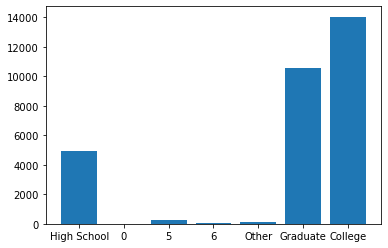

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## plotting the categories for education
counts = spark_df.select('EDUCATION').groupBy('EDUCATION').count().collect()
x = [x['EDUCATION'] for x in counts]
y = [x['count'] for x in counts]

plt.bar(x, y)

<BarContainer object of 4 artists>

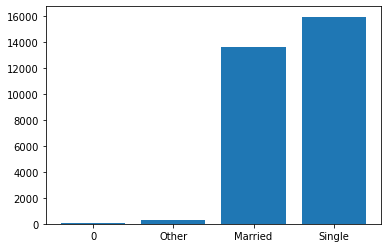

In [12]:
## plotting the categories for marriage

counts = spark_df.select('MARRIAGE').groupBy('MARRIAGE').count().collect()

x = [x['MARRIAGE'] for x in counts]
y = [x['count'] for x in counts]

plt.bar(x,y)

It looks like there are barely any of the 0 and 5 categories. We can go ahead and throw them into the "Other" category since it's already operating as a catchall here. Similarly, the category "0" looks small, so let's throw it in with the "Other" values. You can do this by using a method called `.when()` from PySpark in conjunction with `.withColumn()` and `.otherwise()`.  

In [13]:
from pyspark.sql.functions import when

## changing the values in the education column
spark_df_2 = spark_df.withColumn('EDUCATION',
                    when(spark_df.EDUCATION == '0', 'Other')\
                    .when(spark_df.EDUCATION == '5', 'Other')\
                    .when(spark_df.EDUCATION == '6', 'Other')\
                    .otherwise(spark_df['EDUCATION']))

In [14]:
from pyspark.sql.functions import when

## changing the values in the education column
spark_df2 = spark_df.withColumn('EDUCATION',
                                    when(spark_df.EDUCATION == 0, 'Other')\
                                    .when(spark_df.EDUCATION == 5, 'Other')\
                                    .when(spark_df.EDUCATION == 6, 'Other')\
                                    .otherwise(spark_df['EDUCATION'])
                                    )

## changing the values in the marriage column

spark_df_done = spark_df2.withColumn('MARRIAGE',
                                    when(spark_df2.MARRIAGE == 0, 'Other')\
                                    .otherwise(spark_df2['MARRIAGE']))

In [15]:
spark_df_done.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

Now let's take a look at all the values contained in the categorical columns of the DataFrame: 

In [16]:
for column, data_type in spark_df_done.dtypes:
    # your code here
    if data_type == 'string':
        print (f'Feature {column} has:', spark_df_done.select(column).distinct().collect())

Feature SEX has: [Row(SEX='Female'), Row(SEX='Male')]
Feature EDUCATION has: [Row(EDUCATION='High School'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature MARRIAGE has: [Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  EDA

Let's first look at the overall distribution of class balance of the default and not default labels. Create a barplot to compare the number of defaults vs. non-defaults. This will require using `.groupBy()` as well as an aggregation method.

In [17]:
counts = spark_df_done.groupBy('Default').count().collect()

([<matplotlib.axis.XTick at 0x7fa086e44a60>,
 [Text(0, 0, 'No Default'), Text(1, 0, 'Default')])

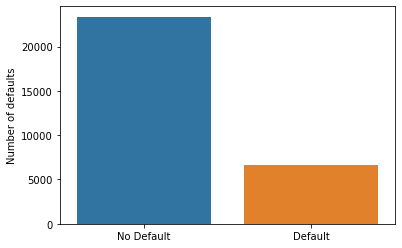

In [18]:
x = [x['Default'] for x in counts]
y = [x['count'] for x in counts]
sns.barplot(x=x, y=y)

plt.ylabel('Number of defaults')
plt.xticks([0,1], ['No Default', 'Default'])

Let's also visualize the difference in default rate between males and females in this dataset.

In [19]:
# perform a groupby for default and sex
counts = spark_df_done.groupBy(['Default', 'SEX']).count().collect()
counts

[Row(Default=1, SEX='Female', count=3762),
 Row(Default=0, SEX='Male', count=9015),
 Row(Default=1, SEX='Male', count=2873),
 Row(Default=0, SEX='Female', count=14349)]

<AxesSubplot:xlabel='1', ylabel='2'>

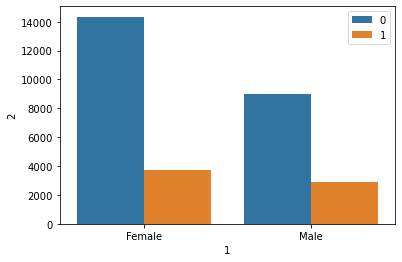

In [20]:
# make barplot for female and male default v no default rate
import pandas as pd
#pd.DataFrame(counts)

sns.barplot(x=1, y=2, hue=0, data=pd.DataFrame(counts))

Text(0.5, 1.0, 'Female Default Counts')

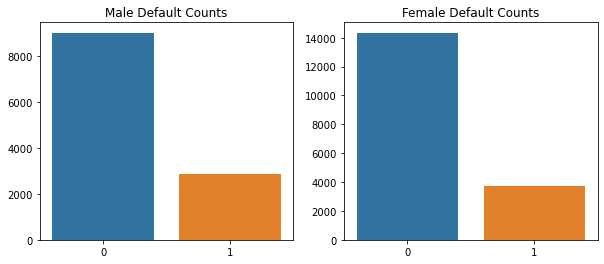

In [21]:
# replot as separate charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

male_x = [x['Default'] for x in counts if x['SEX'] == 'Male']
male_y = [x['count'] for x in counts if x['SEX'] == 'Male']
female_x = [x['Default'] for x in counts if x['SEX'] == 'Female']
female_y = [x['count'] for x in counts if x['SEX'] == 'Female']

sns.barplot(x=male_x, y=male_y, ax=ax1)
ax1.set_title('Male Default Counts')
sns.barplot(x=female_x, y=female_y, ax=ax2)
ax2.set_title('Female Default Counts')

It looks like males have an ever so slightly higher default rate than females.

## Onto the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 StringIndexers (for each categorical feature)
* A OneHotEncoderEstimator (to encode the newly indexed strings into categorical variables)
* A VectorAssembler (to combine all features into one SparseVector)

All of these initialized estimators should be stored in a list.

In [22]:
print(spark_df.columns)

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default']


In [23]:
# importing the necessary modules
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# creating the string indexers
sex_stringi = StringIndexer(inputCol='SEX', outputCol='SEX_num', handleInvalid='keep')
marraige_stringi = StringIndexer(inputCol='MARRIAGE', outputCol='MARRIAGE_num', handleInvalid='keep')
education_stringi = StringIndexer(inputCol='EDUCATION', outputCol='EDUCATION_num', handleInvalid='keep')


ohe = OneHotEncoder(inputCols=['SEX_num', 'EDUCATION_num', 'MARRIAGE_num'], 
                    outputCols=['SEX_vec', 'EDUCATION_vec', 'MARRIAGE_vec'], dropLast=True)


# features to be included in the model 
features = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# adding the categorical features
features += ['SEX_vec', 'EDUCATION_vec', 'MARRIAGE_vec']

print(f'there are {len(features)}')
# putting all of the features into a single vector
va = VectorAssembler(inputCols=features, outputCol='features')

stages = [sex_stringi, marraige_stringi, education_stringi, ohe, va]




there are 23


Alright! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [24]:
from pyspark.ml.pipeline import Pipeline
pipe = Pipeline(stages=stages)

df_tx = pipe.fit(spark_df_done).transform(spark_df_done)
df_tx.select('features').head()

# 17 numerical features and 6 categorical ones (the argument dropLast = True makes us have Sex, 3 Edu variables and 2 marriage)

Row(features=SparseVector(29, {0: 120000.0, 1: 26.0, 2: -1.0, 3: 2.0, 7: 2.0, 8: 2682.0, 9: 1725.0, 10: 2682.0, 11: 3272.0, 12: 3455.0, 13: 3261.0, 15: 1000.0, 16: 1000.0, 17: 1000.0, 19: 2000.0, 20: 1.0, 22: 1.0, 26: 1.0}))

In [25]:
stages = []
indexers = []

# creating the string indexers
for col in ['EDUCATION','SEX','MARRIAGE']:
    indexers.append(StringIndexer(inputCol =col,outputCol=col+'_',handleInvalid='keep'))
    
input_columns = [indexer.getOutputCol() for indexer in indexers]

one_hot_encoder = OneHotEncoder(inputCols=input_columns,outputCols=[col + 'ohe' for col in input_columns],dropLast=True)


# features to be included in the model 
features = ['LIMIT_BAL','AGE','PAY_0','PAY_2','PAY_3',
            'PAY_4','PAY_5','PAY_6', 'BILL_AMT1','BILL_AMT2',
            'BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

# adding the categorical features
features.extend(one_hot_encoder.getOutputCols())

# putting all of the features into a single vector
vector_assember = VectorAssembler(inputCols= features , outputCol='features')

stages.extend(indexers)
stages.extend([one_hot_encoder,vector_assember])
pipe = Pipeline(stages=stages)
data_transformer = pipe.fit(spark_df_done)
transformed_data = data_transformer.transform(spark_df_done)
p = transformed_data.select('features')
p.head()

Row(features=SparseVector(23, {0: 120000.0, 1: 26.0, 2: -1.0, 3: 2.0, 7: 2.0, 8: 2682.0, 9: 1725.0, 10: 2682.0, 11: 3272.0, 12: 3455.0, 13: 3261.0, 14: 1.0, 18: 1.0, 20: 1.0}))

## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`. Below is an import of all the classes and libraries you'll need in the remainder of this lab.

In [26]:
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

### Logistic Regression

First, we'll try with a simple Logistic Regression Model:

* instantiate a logistic regression model
* add it to the stages list
* instantiate a new Pipeline estimator (not fit) with all of the stages
* instantiate an `BinaryClassificationEvaluator`
* create parameters to gridsearch through using `ParamGridBuilder`
* Instantiate and fit a `CrossValidator` 

In [27]:
# your code here
logreg = LogisticRegression(featuresCol='features', labelCol='default')

In [28]:
stages.append(logreg)

bce = BinaryClassificationEvaluator(labelCol='default')


logreg_pipe = Pipeline(stages=stages)


params = ParamGridBuilder()\
.addGrid(logreg.regParam, [0, 0.2, 0.8])\
.addGrid(logreg.standardization, [True, False])\
.build()

cv = CrossValidator(estimator=logreg_pipe, estimatorParamMaps=params, evaluator=bce)

In [29]:
model = cv.fit(spark_df_done)

Determine how well your model performed by looking at the evaluator metrics. If you tried multiple parameters, which performed best?

In [34]:
# print out the AUC of your best model as well as the parameters of your best model
best_idx = np.argmax(model.avgMetrics)
print('Best Score:', model.avgMetrics[best_idx])
print('Best params:', params[best_idx])

Best Score: 0.7175663827361789
Best params: {Param(parent='LogisticRegression_f995da771b14', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_f995da771b14', name='standardization', doc='whether to standardize the training features before fitting the model.'): True}


#### Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated model as well as print out the performance metrics of the best performing model and the best parameters.

In [35]:
# create function to cross validate models with different parameters

def test_model(evaluator, params):
    stages = [sex_stringi, marraige_stringi, education_stringi, ohe, va]
    stages.append(evaluator)
    bce = BinaryClassificationEvaluator(labelCol='default')
    pipe = Pipeline(stages=stages)
    cv = CrossValidator(estimator=pipe, estimatorParamMaps=params, evaluator=bce, parallelism=2)
    model = cv.fit(spark_df_done)
    best_idx = np.argmax(model.avgMetrics)
    print('Best Score:', model.avgMetrics[best_idx])
    print('Best params:', params[best_idx])
    
    return model

Train a Random Forest classifier and determine the best performing model with the best parameters. This might take a while! Be smart about how you use parallelization here.

In [40]:
# code to train Random Forest Classifier
# ⏰ This cell may take a long time to run


rf = RandomForestClassifier(featuresCol='features', labelCol='default')

param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 15])\
                               .addGrid(rf.numTrees, [20, 50])\
                               .build()

rf_model = test_model(rf, param_grid)


Best Score: 0.7764352255779499
Best params: {Param(parent='RandomForestClassifier_14b5aa8e5574', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_14b5aa8e5574', name='numTrees', doc='Number of trees to train (>= 1).'): 50}


Now train a Gradient Boosting Classifier. **This might take a very long time depending on the number of parameters you are training**

In [39]:
# code to train Gradient Boosting Classifier
# ⏰ This cell may take a long time to run
gb = GBTClassifier(featuresCol='features', labelCol='default')

param_grid = ParamGridBuilder().addGrid(gb.stepSize, [0.1, 0.2])\
                               .addGrid(gb.maxDepth, [10, 20])\
                               .build()

test_model(gb, param_grid)

Best Score: 0.7424660311691056
Best params: {Param(parent='GBTClassifier_f48b7936c3b4', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1, Param(parent='GBTClassifier_f48b7936c3b4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}


CrossValidatorModel_fb5efc289136

It looks like the optimal performing model is the Random Forest Classifier Model because it has the highest AUC!

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

In [51]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [50]:
rf_model.summary
BinaryClassificationMetrics()
#.summary.roc.select('FPR').collect()


AttributeError: 'CrossValidatorModel' object has no attribute 'summary'

## Summary

If you've made it thus far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.